# Modelo de Classificação com Stacking Ensemble

Este notebook implementa um modelo de classificação utilizando **Stacking Ensemble** com os seguintes algoritmos:
- RandomForest
- XGBoost  
- LightGBM

O pipeline inclui técnicas de balanceamento de classes (SMOTE e Undersampling) e otimização de hiperparâmetros com Optuna.

## 1. Importação das Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import  train_test_split

## 2. Carregamento dos Dados

In [2]:
X_train = pd.read_csv('Dados/Xtrain.csv')
y_train = pd.read_csv('Dados/ytrain.csv')
X_test = pd.read_csv('Dados/test.csv')
id_test = X_test['id']
X_test= X_test.drop('id',axis=1)

## 3. Pré-processamento

### 3.1 Normalização (StandardScaler)

In [3]:
scaler = StandardScaler()


X_train[["Amount","Time"]] = scaler.fit_transform(X_train[["Amount","Time"]])

X_test[["Amount","Time"]] = scaler.transform(X_test[["Amount","Time"]])

### 3.2 Transformação de Potência (Yeo-Johnson)

In [4]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson', copy=True)
pt.fit(X_train)

X_train = pt.transform(X_train)
X_test =pt.transform(X_test)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

## 4. Otimização de Hiperparâmetros com Optuna

Utilizamos Optuna para encontrar os melhores hiperparâmetros do modelo Stacking com validação cruzada.

In [6]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=400, max_depth=25, random_state=42, n_jobs=-1)),
    ('xgb', XGBClassifier(n_estimators=400, learning_rate=0.01, max_depth=25,
                          use_label_encoder=False, eval_metric='auc', random_state=42, n_jobs=-1)),
    ('lgbm', LGBMClassifier(n_estimators=400, learning_rate=0.01, random_state=42, n_jobs=-1, verbose=-1))
]


smote_step = BorderlineSMOTE(sampling_strategy={1: 1000}, random_state=42, kind='borderline-1')
under_step = RandomUnderSampler(sampling_strategy={0: 60000}, random_state=42)


meta_learner = LogisticRegression(C=0.1, random_state=42)


final_pipeline = Pipeline([
    ('smote', smote_step),
    ('undersample', under_step),
    ('stacking', StackingClassifier(estimators=estimators, final_estimator=meta_learner, cv=3, n_jobs=-1))
])

## 5. Treinamento do Modelo Final

Treinamento do modelo com os melhores parâmetros encontrados.

In [7]:
print("Starting Training of Final Stacking Model...")
final_pipeline.fit(X_train, y_train)
print("Training Complete.")


y_probs = final_pipeline.predict_proba(X_val)[:, 1]


precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs)

beta = 2
f2_scores = ((1 + beta**2) * precisions * recalls) / ((beta**2 * precisions) + recalls)
f2_scores = np.nan_to_num(f2_scores)


optimal_idx = np.argmax(f2_scores)
best_threshold = thresholds[optimal_idx]

print(f"\n--- THRESHOLD OPTIMIZATION RESULTS ---")
print(f"Optimal Decision Threshold: {best_threshold:.4f}")
print(f"Max F2-Score at this Threshold: {np.max(f2_scores):.4f}")

Starting Training of Final Stacking Model...


c:\Users\jairo\PycharmProjects\LIGIA\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jairo\PycharmProjects\LIGIA\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training Complete.

--- THRESHOLD OPTIMIZATION RESULTS ---
Optimal Decision Threshold: 0.0756
Max F2-Score at this Threshold: 0.8396


In [8]:
auc = roc_auc_score(y_val,y_probs)
print(f"Max ROC-au at this Threshold: {np.max(auc):.4f}")

Max ROC-au at this Threshold: 0.9721


## 6. Avaliação do Modelo

Métricas de performance no conjunto de validação.

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, fbeta_score, roc_auc_score, 
    confusion_matrix, classification_report, 
    average_precision_score, matthews_corrcoef, balanced_accuracy_score
)
from sklearn.model_selection import cross_val_predict
import warnings
warnings.filterwarnings('ignore')

y_pred_val = final_pipeline.predict(X_val)
y_pred_proba_val = final_pipeline.predict_proba(X_val)[:, 1]

print("=" * 60)
print("MÉTRICAS DE AVALIAÇÃO DO MODELO (Conjunto Balanceado)")
print("=" * 60)

print(f"\n MÉTRICAS DE CLASSIFICAÇÃO:")
print(f"   Accuracy:           {accuracy_score(y_val, y_pred_val):.4f}")
print(f"   Balanced Accuracy:  {balanced_accuracy_score(y_val, y_pred_val):.4f}")
print(f"   Precision:          {precision_score(y_val, y_pred_val):.4f}")
print(f"   Recall (Sensit.):   {recall_score(y_val, y_pred_val):.4f}")
print(f"   F1-Score:           {f1_score(y_val, y_pred_val):.4f}")
print(f"   F2-Score:           {fbeta_score(y_val, y_pred_val, beta=2):.4f}")
print(f"   F0.5-Score:         {fbeta_score(y_val, y_pred_val, beta=0.5):.4f}")

print(f"\n MÉTRICAS DE PROBABILIDADE:")
print(f"   ROC-AUC Score:      {roc_auc_score(y_val, y_pred_proba_val):.4f}")
print(f"   PR-AUC Score:       {average_precision_score(y_val, y_pred_proba_val):.4f}")

print(f"\n OUTRAS MÉTRICAS:")
print(f"   Matthews Corr.:     {matthews_corrcoef(y_val, y_pred_val):.4f}")

print(f"\n MATRIZ DE CONFUSÃO:")
cm = confusion_matrix(y_val, y_pred_val)
print(f"   TN: {cm[0,0]:>6}  |  FP: {cm[0,1]:>6}")
print(f"   FN: {cm[1,0]:>6}  |  TP: {cm[1,1]:>6}")

print(f"\n RELATÓRIO DE CLASSIFICAÇÃO:")
print(classification_report(y_val, y_pred_val, target_names=['Não Fraude (0)', 'Fraude (1)']))

y_proba = final_pipeline.predict_proba(X_test)[:, 1]
print("=" * 60)
print(" Predições no conjunto de teste geradas com sucesso!")
print("=" * 60)

MÉTRICAS DE AVALIAÇÃO DO MODELO (Conjunto Balanceado)

 MÉTRICAS DE CLASSIFICAÇÃO:
   Accuracy:           0.9994
   Balanced Accuracy:  0.8860
   Precision:          0.8472
   Recall (Sensit.):   0.7722
   F1-Score:           0.8079
   F2-Score:           0.7861
   F0.5-Score:         0.8311

 MÉTRICAS DE PROBABILIDADE:
   ROC-AUC Score:      0.9721
   PR-AUC Score:       0.8246

 OUTRAS MÉTRICAS:
   Matthews Corr.:     0.8085

 MATRIZ DE CONFUSÃO:
   TN:  45479  |  FP:     11
   FN:     18  |  TP:     61

 RELATÓRIO DE CLASSIFICAÇÃO:
                precision    recall  f1-score   support

Não Fraude (0)       1.00      1.00      1.00     45490
    Fraude (1)       0.85      0.77      0.81        79

      accuracy                           1.00     45569
     macro avg       0.92      0.89      0.90     45569
  weighted avg       1.00      1.00      1.00     45569

 Predições no conjunto de teste geradas com sucesso!


## 7. Geração do Arquivo de Submissão

In [10]:
submission = pd.DataFrame({
    'id': id_test,
    'target': y_proba
})

submission.to_csv('submission.csv', index=False)

print("Arquivo gerado com sucesso!")
print(submission.head())

Arquivo gerado com sucesso!
       id    target
0  263021  0.001758
1   11379  0.001773
2  147284  0.002077
3  219440  0.001757
4   36940  0.001924


## 8. Feature Importance dos Modelos Base

Visualização da importância das features para cada modelo do Stacking Ensemble.

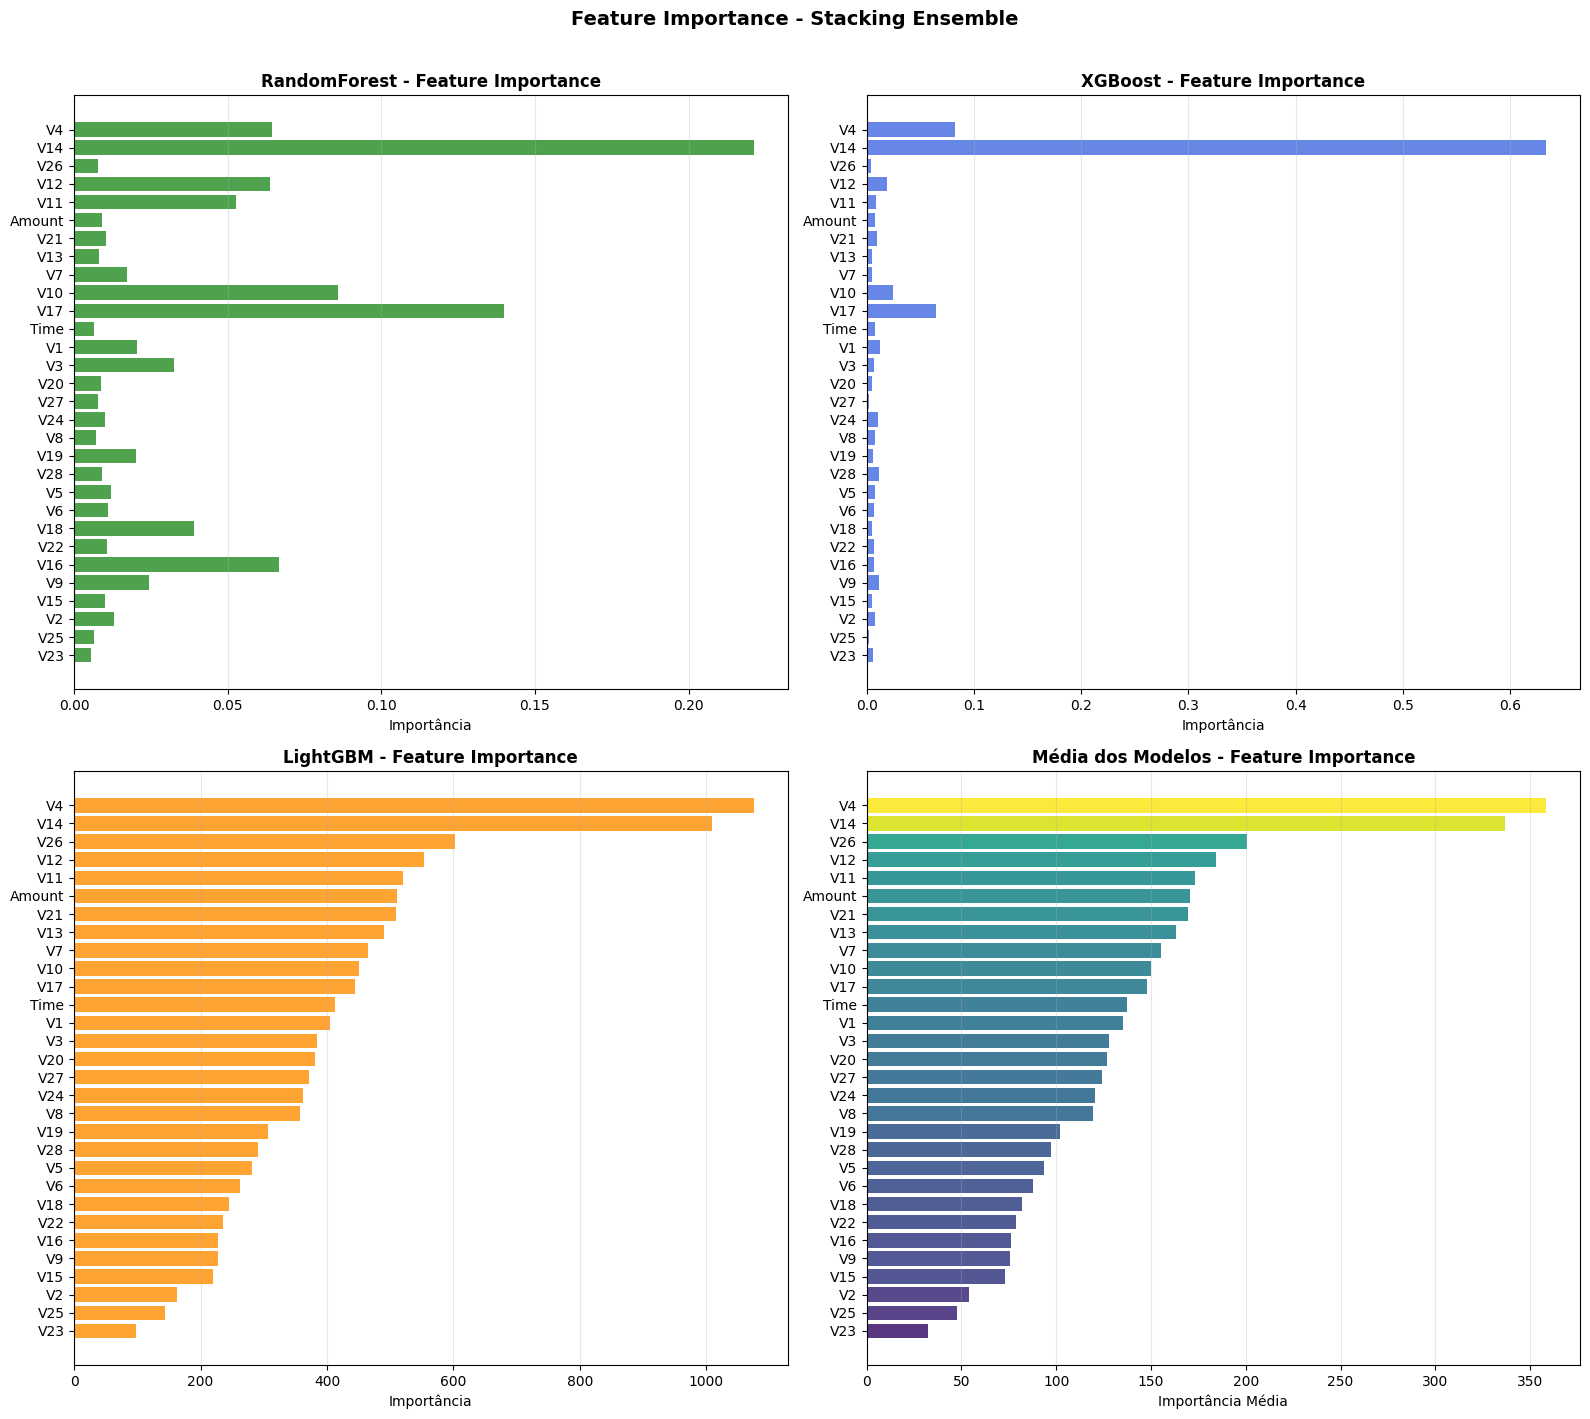


TOP 10 FEATURES MAIS IMPORTANTES (Média dos Modelos)
Feature  RandomForest  XGBoost  LightGBM      Média
     V4      0.064235 0.082458      1075 358.382231
    V14      0.221157 0.633514      1009 336.618224
    V26      0.007669 0.004158       602 200.670609
    V12      0.063661 0.018626       553 184.360762
    V11      0.052753 0.008464       520 173.353739
 Amount      0.009102 0.007378       511 170.338827
    V21      0.010222 0.009284       509 169.673169
    V13      0.008173 0.004749       490 163.337641
     V7      0.017064 0.004972       465 155.007345
    V10      0.085835 0.024822       450 150.036886


In [ ]:
import matplotlib.pyplot as plt

feature_names = pd.read_csv('Dados/Xtrain.csv').columns.tolist()

stacking_model = final_pipeline.named_steps['stacking']

# Extrair importâncias de cada modelo base
rf_model = stacking_model.named_estimators_['rf']
xgb_model = stacking_model.named_estimators_['xgb']
lgbm_model = stacking_model.named_estimators_['lgbm']

# Criar DataFrame com as importâncias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'RandomForest': rf_model.feature_importances_,
    'XGBoost': xgb_model.feature_importances_,
    'LightGBM': lgbm_model.feature_importances_
})

# Calcular importância média
importance_df['Média'] = importance_df[['RandomForest', 'XGBoost', 'LightGBM']].mean(axis=1)
importance_df = importance_df.sort_values('Média', ascending=True)

# Criar figura com subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: RandomForest
ax1 = axes[0, 0]
ax1.barh(importance_df['Feature'], importance_df['RandomForest'], color='forestgreen', alpha=0.8)
ax1.set_xlabel('Importância')
ax1.set_title('RandomForest - Feature Importance', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: XGBoost
ax2 = axes[0, 1]
ax2.barh(importance_df['Feature'], importance_df['XGBoost'], color='royalblue', alpha=0.8)
ax2.set_xlabel('Importância')
ax2.set_title('XGBoost - Feature Importance', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: LightGBM
ax3 = axes[1, 0]
ax3.barh(importance_df['Feature'], importance_df['LightGBM'], color='darkorange', alpha=0.8)
ax3.set_xlabel('Importância')
ax3.set_title('LightGBM - Feature Importance', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Média de todos os modelos
ax4 = axes[1, 1]
colors = plt.cm.viridis(importance_df['Média'] / importance_df['Média'].max())
ax4.barh(importance_df['Feature'], importance_df['Média'], color=colors, alpha=0.9)
ax4.set_xlabel('Importância Média')
ax4.set_title('Média dos Modelos - Feature Importance', fontsize=12, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

plt.suptitle('Feature Importance - Stacking Ensemble', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Mostrar Top 10 features mais importantes
print("\n" + "=" * 60)
print("TOP 10 FEATURES MAIS IMPORTANTES (Média dos Modelos)")
print("=" * 60)
top_10 = importance_df.nlargest(10, 'Média')[['Feature', 'RandomForest', 'XGBoost', 'LightGBM', 'Média']]
print(top_10.to_string(index=False))

## 9. Salvando o Modelo

Exportação do pipeline completo e objetos de pré-processamento para uso em produção.

In [ ]:
import joblib

joblib.dump(final_pipeline, 'modelo_stacking.joblib')

joblib.dump(scaler, 'scaler.joblib')
joblib.dump(pt, 'power_transformer.joblib')

joblib.dump(best_threshold, 'best_threshold.joblib')

joblib.dump(feature_names, 'feature_names.joblib')

print("=" * 60)
print("MODELOS SALVOS COM SUCESSO!")
print("=" * 60)
print("Arquivos gerados:")
print("  - modelo_stacking.joblib")
print("  - scaler.joblib")
print("  - power_transformer.joblib")
print("  - best_threshold.joblib")
print("  - feature_names.joblib")

MODELOS SALVOS COM SUCESSO!
Arquivos gerados:
  - modelo_stacking.joblib
  - scaler.joblib
  - power_transformer.joblib
  - best_threshold.joblib
  - feature_names.joblib
